In [33]:
import numpy as np
import pickle
import tensorly as tf
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sktime.datasets import load_basic_motions
from sktime.transformations.panel.rocket import Rocket
from sktime.transformations.panel.padder import PaddingTransformer
import pandas as pd
import warnings
import time
from MUDRA import MUDRA
from sklearn.preprocessing import normalize

## for the purpose of readability
import warnings
warnings.filterwarnings("ignore")

rng = np.random.default_rng()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

cmap = plt.cm.Spectral(np.linspace(0, 1, 25))

In [8]:
def nearPSD(X):
    
    assert len(X.shape) == 2
    X = (X + X.T) / 2
    D, Q = np.linalg.eigh(X)
    D = np.clip(D, 0, np.inf)
    return Q @ np.diag(D) @ Q.T

In [9]:
def matSqrt(X):
    
    assert len(X.shape) == 2
    X = (X + X.T) / 2
    D, Q = np.linalg.eigh(X)
    D = np.sqrt(np.clip(D, 0, np.inf))
    return Q @ np.diag(D) @ Q.T

# Data Loading and Preprocessing

The data is in the form of two lists: $X$ and $y$, each of size `n_samples`. $y$ is simply a list of targets, where each element is the class that the corresponding element in $X$ belongs to. $X$ is a list of $(T_i+1)\times(F_i+1)$ matrices, where the first column stores the timepoints and the first row stores the features recorded for each sample. The other elements are feature values at the corresponding timepoints.

## Data Loading and Plotting

The data is loaded from the `data.pickle` file, and one sample from each class is plotted. Each plot represents one feature, and each colour represents one class.

# Model

The model is implemented as an instance of a scikit-learn `estimator` class. It implements interface functions `transform`, `fit_transform`, `predict`, `predict_proba` and `predict_log_proba` according to the specification, and can also be used in the beginning of a scikit-learn `Pipeline` in order to transform irregular tensor data into an `n_samples`$\times$`r` matrix, which can then be further processed using other scikit-learn estimators.

Assume that data is recorded at $T$ timepoints and for $F$ features. Let there be $K$ classes $i=1,2,\ldots,K$ and $j=1,2,\ldots,m_i$ subjects in each class. For each subject, let the timepoints recorded be $t_1, t_2,\ldots,t_{T_{ij}}$ and the features recorded be $f_1,f_2,\ldots,f_{F_{ij}}$. The model can be described as $$Y_{ij}=S_{ij}(\lambda_0 + \Lambda\alpha_i\xi + \gamma_{ij})C_{ij} + \epsilon_{ij}$$
Here $Y_{ij}\in\mathbb{R}^{T_{ij}\times F_{ij}}$ are the data matrices, where each row is a timepoint and each column is a feature. $S_{ij}$s are the spline matrices, formed from the spline basis function set $\{\mathbf{s}_1(t), \mathbf{s}_2(t),\ldots,\mathbf{s}_b(t)\}$. Similar to $Y_{ij}$, the rows are timepoints and the columns are basis functions, so the matrix is defined as $$S_{ij}=\begin{bmatrix}
\mathbf{s}_1(t_1) &\mathbf{s}_2(t_1) &\cdots &\mathbf{s}_b(t_1)\\
\mathbf{s}_1(t_2) &\mathbf{s}_2(t_2) &\cdots &\mathbf{s}_b(t_2)\\
&\vdots\\
\mathbf{s}_1(t_{T_{ij}}) &\mathbf{s}_2(t_{T_{ij}}) &\cdots &\mathbf{s}_b(t_{T_{ij}})\\
\end{bmatrix}$$ $C_{ij}\in\mathbb{R}^{F\times F_{ij}}$ are the $\{f_1^{th}, f_2^{th},\ldots,f_{F_{ij}}^{th}\}$ columns of an $F\times F$ identity matrix, $\lambda_0\in\mathbb{R}^{b\times F}$ is the mean parameter, $\alpha_i\in\mathbb{R}^{r\times r}$s are the reduced rank linear discriminants, $\Lambda\in\mathbb{R}^{b\times r}$ and $\xi\in\mathbb{R}^{r\times F}$ are matrices used to compute the full rank linear discriminants, $\gamma_{ij}\in\mathcal{N}_{b\times F}(0,\Sigma,\Psi)$ is the internal autoregressive noise and $\epsilon_{ij}\sim\mathcal{N}_{T_{ij}\times F_{ij}}(0,\sigma^2I)$ is the measurement noise.
We use an ECM algorithm to fit the model to the data, for computational efficiency.

## Missing Data

In [10]:
X, y = pickle.load(open("datasets/trainWordRecognitionMissing.pickle", 'rb'))
X_test, y_test = pickle.load(open("datasets/testWordRecognitionReducedMissing.pickle", 'rb'))

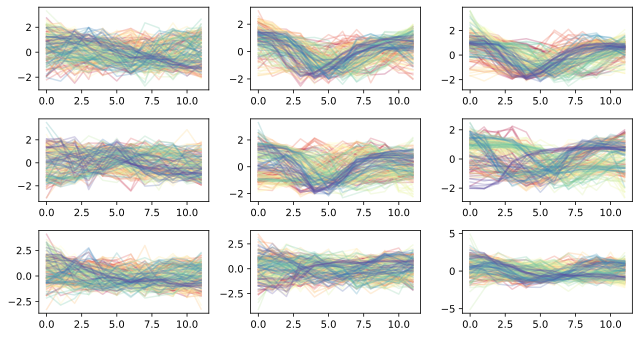

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=3)
fig.set_figwidth(9)
for i in range(len(X)):
    featIdx = X[i][0,1:].astype('int')
    for col, j in enumerate(featIdx):
        ax[j//3, j%3].plot(X[i][1:,0], X[i][1:,col+1], color=cmap[y[i] - 1], alpha=0.25)
fig.tight_layout()

In [12]:
model = MUDRA(r=8, n_iter=300, nBasis=9).fit(X, y)

In [13]:
x = model.transform(X)
classifier = RidgeClassifierCV().fit(x, y)
x = model.transform(X_test)
print(classification_report(y_test, classifier.predict(x)))

              precision    recall  f1-score   support

           1       0.71      0.83      0.77        12
           2       0.67      0.83      0.74        12
           3       0.91      0.83      0.87        12
           4       1.00      0.83      0.91        12
           5       0.80      1.00      0.89        12
           6       0.60      1.00      0.75        12
           7       0.71      0.83      0.77        12
           8       0.78      0.58      0.67        12
           9       0.92      0.92      0.92        12
          10       0.92      0.92      0.92        12
          11       0.85      0.92      0.88        12
          12       1.00      0.83      0.91        12
          13       0.67      0.83      0.74        12
          14       0.90      0.75      0.82        12
          15       1.00      0.83      0.91        12
          16       1.00      0.33      0.50        12
          17       0.82      0.75      0.78        12
          18       1.00    

### Padding Type-1: "imputation"

In [14]:
paddedX = []
for i in range(len(X)):
    currX = X[i]
    newX = currX[0,:]
    prevTPoint = -1
    for idx, tPoint in enumerate(currX[1:,0]):
        if tPoint - prevTPoint > 1:
            for j in range((tPoint - prevTPoint - 1).astype('int')):
                newX = np.vstack((newX, np.zeros(currX.shape[1])))
        newX = np.vstack((newX, currX[idx+1,:]))
        prevTPoint = tPoint
    if prevTPoint < 11.:
        for j in range((11 - prevTPoint).astype('int')):
            newX = np.vstack((newX, np.zeros(currX.shape[1])))
    newX[1:,0] = np.arange(12)
    currX = newX
    newX = np.atleast_2d(currX[:,0]).T
    prevFeat = -1
    for idx, feat in enumerate(currX[0,1:]):
        if feat - prevFeat > 1:
            for j in range((feat - prevFeat - 1).astype('int')):
                newX = np.hstack((newX, np.zeros((currX.shape[0], 1))))
        newX = np.hstack((newX, np.atleast_2d(currX[:,idx+1]).T))
        prevFeat = feat
    if prevFeat < 8:
        for j in range((8 - prevFeat).astype('int')):
            newX = np.hstack((newX, np.zeros((currX.shape[0], 1))))
    newX[0,1:] = np.arange(9)
    paddedX.append(newX)

In [15]:
paddedX_test = []
for i in range(len(X_test)):
    currX = X_test[i]
    newX = currX[0,:]
    prevTPoint = -1
    for idx, tPoint in enumerate(currX[1:,0]):
        if tPoint - prevTPoint > 1:
            for j in range((tPoint - prevTPoint - 1).astype('int')):
                newX = np.vstack((newX, np.zeros(currX.shape[1])))
        newX = np.vstack((newX, currX[idx+1,:]))
        prevTPoint = tPoint
    if prevTPoint < 11.:
        for j in range((11 - prevTPoint).astype('int')):
            newX = np.vstack((newX, np.zeros(currX.shape[1])))
    newX[1:,0] = np.arange(12)
    currX = newX
    newX = np.atleast_2d(currX[:,0]).T
    prevFeat = -1
    for idx, feat in enumerate(currX[0,1:]):
        if feat - prevFeat > 1:
            for j in range((feat - prevFeat - 1).astype('int')):
                newX = np.hstack((newX, np.zeros((currX.shape[0], 1))))
        newX = np.hstack((newX, np.atleast_2d(currX[:,idx+1]).T))
        prevFeat = feat
    if prevFeat < 8:
        for j in range((8 - prevFeat).astype('int')):
            newX = np.hstack((newX, np.zeros((currX.shape[0], 1))))
    newX[0,1:] = np.arange(9)
    paddedX_test.append(newX)

In [16]:
rocketPipeline = make_pipeline(Rocket(num_kernels=41), RidgeClassifierCV())
x = pd.DataFrame([[pd.Series(paddedX[j][1:,i]) for i in range(1, 10)] for j in range(275)])
rocketPipeline.fit(x, y)
x = pd.DataFrame([[pd.Series(paddedX_test[j][1:,i]) for i in range(1, 10)] for j in range(300)])
print(classification_report(y_test, rocketPipeline.predict(x)))

              precision    recall  f1-score   support

           1       0.70      0.58      0.64        12
           2       0.41      0.75      0.53        12
           3       0.85      0.92      0.88        12
           4       0.58      0.58      0.58        12
           5       0.71      0.83      0.77        12
           6       0.56      0.75      0.64        12
           7       0.62      0.67      0.64        12
           8       0.67      0.50      0.57        12
           9       0.62      0.42      0.50        12
          10       1.00      0.42      0.59        12
          11       0.43      0.50      0.46        12
          12       0.50      0.67      0.57        12
          13       0.62      0.67      0.64        12
          14       0.40      0.50      0.44        12
          15       0.64      0.58      0.61        12
          16       0.29      0.33      0.31        12
          17       0.57      0.33      0.42        12
          18       0.70    

### Padding Type-2: "end"

In [17]:
paddedX = []
for i in range(len(X)):
    currX  = X[i]
    newX = np.atleast_2d(currX[:,0]).T
    prevFeat = -1
    for idx, feat in enumerate(currX[0,1:]):
        if feat - prevFeat > 1:
            for j in range((feat - prevFeat - 1).astype('int')):
                newX = np.hstack((newX, np.zeros((currX.shape[0], 1))))
        newX = np.hstack((newX, np.atleast_2d(currX[:,idx+1]).T))
        prevFeat = feat
    if prevFeat < 8:
        for j in range((8 - prevFeat).astype('int')):
            newX = np.hstack((newX, np.zeros((currX.shape[0], 1))))
    newX[0,1:] = np.arange(9)
    paddedX.append(newX)

In [18]:
paddedX_test = []
for i in range(len(X_test)):
    currX  = X_test[i]
    newX = np.atleast_2d(currX[:,0]).T
    prevFeat = -1
    for idx, feat in enumerate(currX[0,1:]):
        if feat - prevFeat > 1:
            for j in range((feat - prevFeat - 1).astype('int')):
                newX = np.hstack((newX, np.zeros((currX.shape[0], 1))))
        newX = np.hstack((newX, np.atleast_2d(currX[:,idx+1]).T))
        prevFeat = feat
    if prevFeat < 8:
        for j in range((8 - prevFeat).astype('int')):
            newX = np.hstack((newX, np.zeros((currX.shape[0], 1))))
    newX[0,1:] = np.arange(9)
    paddedX_test.append(newX)

In [19]:
rocketPipeline = make_pipeline(PaddingTransformer(), Rocket(num_kernels=41), RidgeClassifierCV())
x = pd.DataFrame([[pd.Series(paddedX[j][1:,i]) for i in range(1, 10)] for j in range(275)])
rocketPipeline = rocketPipeline.fit(x, y)
x = pd.DataFrame([[pd.Series(paddedX_test[j][1:,i]) for i in range(1, 10)] for j in range(300)])
print(classification_report(y_test, rocketPipeline.predict(x)))

              precision    recall  f1-score   support

           1       0.60      0.25      0.35        12
           2       0.75      0.75      0.75        12
           3       0.62      0.42      0.50        12
           4       0.40      0.33      0.36        12
           5       0.44      0.92      0.59        12
           6       0.47      0.67      0.55        12
           7       0.71      0.83      0.77        12
           8       0.31      0.42      0.36        12
           9       0.43      0.50      0.46        12
          10       0.64      0.58      0.61        12
          11       0.67      0.33      0.44        12
          12       1.00      0.25      0.40        12
          13       0.71      0.42      0.53        12
          14       0.42      0.42      0.42        12
          15       0.46      0.50      0.48        12
          16       0.17      0.08      0.11        12
          17       0.40      0.50      0.44        12
          18       0.29    

## No missing data

In [40]:
X, y = pickle.load(open("datasets/trainWordRecognition.pickle", 'rb'))
X_test, y_test = pickle.load(open("datasets/testWordRecognitionReduced.pickle", 'rb'))

In [15]:
accTable = np.zeros((8, 2))
for r in range(2, 10):
    rocketAccuracy = 0
    modelPipeline = make_pipeline(MUDRA(r=r, n_iter=500, nBasis=9), RidgeClassifierCV())
    rocketPipeline = make_pipeline(Rocket(num_kernels=(r**2 + 1)//2), RidgeClassifierCV())
    for _ in range(10):
        x = pd.DataFrame([[pd.Series(X[j][1:,i]) for i in range(1, 10)] for j in range(275)])
        rocketPipeline.fit(x, y)
        x = pd.DataFrame([[pd.Series(X_test[j][1:,i]) for i in range(1, 10)] for j in range(300)])
        rocketAccuracy += classification_report(y_test, rocketPipeline.predict(x), output_dict=True)['weighted avg']['f1-score']
    rocketAccuracy /= 10
    modelPipeline.fit(X, y)
    modelAccuracy = classification_report(y_test, modelPipeline.predict(X_test), output_dict=True)['weighted avg']['f1-score']
    accTable[r - 2,:] = [modelAccuracy, rocketAccuracy]
pd.DataFrame(accTable, index=range(2, 10), columns=['Model Accuracy', 'Rocket Accuracy']).to_csv('rocket_vs_mudra2.csv')

In [18]:
pd.DataFrame(times, columns=['ROCKET', 'MUDRA']).to_csv('times.csv')

In [19]:
pd.read_csv('rocket_vs_mudra2.csv', index_col=0)

,Model Accuracy,Rocket Accuracy
2,0.321782,0.112656
3,0.712311,0.391590
4,0.794368,0.594992
5,0.782589,0.745976
6,0.905710,0.846826
7,0.890824,0.891402
8,0.925608,0.927237
9,0.932595,0.938595


In [22]:
modelPipeline = make_pipeline(MUDRA(r=9, n_iter=5, nBasis=9), RidgeClassifierCV())

In [23]:
modelPipeline.fit(X, y)

Pipeline(steps=[('mudra',
                 MUDRA(PsiRank=9, SigmaRank=9, nBasis=9, n_iter=5, r=9)),
                ('ridgeclassifiercv', RidgeClassifierCV())])

In [24]:
print(classification_report(y_test, modelPipeline.predict(X_test)))

              precision    recall  f1-score   support

           1       1.00      0.83      0.91        12
           2       0.67      0.83      0.74        12
           3       0.69      0.92      0.79        12
           4       0.83      0.83      0.83        12
           5       0.85      0.92      0.88        12
           6       0.79      0.92      0.85        12
           7       0.65      0.92      0.76        12
           8       0.00      0.00      0.00        12
           9       0.82      0.75      0.78        12
          10       0.80      1.00      0.89        12
          11       1.00      1.00      1.00        12
          12       0.78      0.58      0.67        12
          13       0.73      0.92      0.81        12
          14       0.80      0.67      0.73        12
          15       1.00      0.92      0.96        12
          16       0.62      0.67      0.64        12
          17       0.83      0.83      0.83        12
          18       0.78    

In [26]:
r = 0
for _ in tqdm(range(100)):
    x = pd.DataFrame([[pd.Series(X[j][1:,i]) for i in range(1, 10)] for j in range(275)])
    rocket = Rocket(num_kernels=50).fit(x)
    x = rocket.transform(x)
    classifier = RidgeClassifierCV().fit(x, y)
    x = pd.DataFrame([[pd.Series(X_test[j][1:,i]) for i in range(1, 10)] for j in range(300)])
    x = rocket.transform(x)
    y_pred = classifier.predict(x)
    report = classification_report(y_test, y_pred, output_dict=True)
    r += report['weighted avg']['f1-score']
r /= 100
print(r)

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.



0.9485506015841945


### Measuring Execution Time 

In [41]:
times = np.zeros((100, 2))
modelPipeline = make_pipeline(MUDRA(r=7, n_iter=500, nBasis=9), RidgeClassifierCV())
rocketPipeline = make_pipeline(Rocket(num_kernels=(7**2 + 1)//2), RidgeClassifierCV())
for k in tqdm(range(100)):
    
    x = pd.DataFrame([[pd.Series(X[j][1:,i]) for i in range(1, 10)] for j in range(275)])
    start = time.time()
    rocketPipeline.fit(x, y)
    end = time.time()
    times[k, 0] = end - start
    start = time.time()
    modelPipeline.fit(X, y)
    end = time.time()
    times[k, 1] = end - start

  0%|          | 0/100 [00:00<?, ?it/s]

([<matplotlib.axis.XTick at 0x7f9a4a1bb010>,
 [Text(1, 0, 'ROCKET'), Text(2, 0, 'MUDRA')])

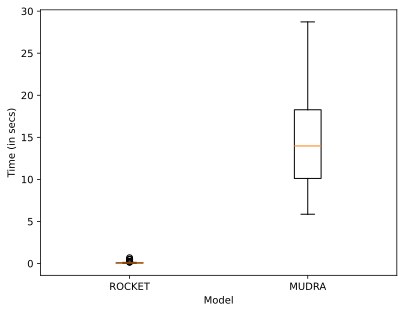

In [42]:
plt.xlabel('Model')
plt.ylabel('Time (in secs)')
plt.boxplot(times)
plt.xticks(np.arange(1, 3), ['ROCKET', 'MUDRA'])
# plt.savefig('time.svg')

# Results

## r=2

### Fitting the data

We run the model with the given input data

In [25]:
model = MUDRA(r=2, n_iter=500, nBasis=6).fit(X, y)
pts = model.transform(X)

### Plot the estimated class functionals

We plot the estimated functionals. Each plot represents one feature, and each colour represents one class.

Let $S$ be the spline basis matrix evaluated at all time points for which any data was recorded. Then the class functionals can simply be estimated as $$Y=S(\lambda_0 + \Lambda\alpha_i\xi)$$, where each column represents one feature functional.

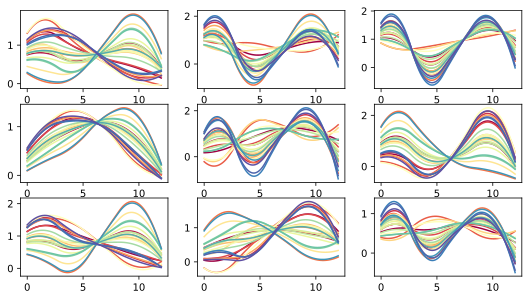

In [26]:
xs = np.linspace(0, 12, 100)
S = model.basis(xs).squeeze().T
fig, ax = plt.subplots(nrows=3, ncols=3)
fig.set_figwidth(9)
for i in range(model.n_classes):
    ys = S @ (model.lambda0_ + model.Lambda_ @ np.diag(model.alpha_[i]) @ model.xi_)
    for j in range(model.n_features):
        ax[j//3, j%3].plot(xs, ys[:,j], color=cmap[i])

### Dimension Reduction

Let $Y$ be a new datapoint that is not in the training set. Similar to training, we will construct the corresponding $S_Y$ and $C_Y$ matrix. Define $M_Y = \sigma^2I + (C^T\Psi C)\otimes (S\Sigma S^T)$ and $A_Y=(\xi C)^T\otimes(S\Lambda)$. Then, we choose $\hat{\alpha}_Y$ such that $$vec(\hat{\alpha}_Y)=(A_Y^TM_Y^{-1}A_Y)^{-\frac{1}{2}}A_Y^TM_Y^{-1}Y$$ Reshaping into an $r\times r$ matrix and taking the diagonal elements, we arrive at an $r$ dimensional representation of $Y$ that has unit covariance, since $var(vec(Y))=A_Y^TM_Y^{-1}A_Y$.

### Classification

Classification of a sample is done by computing the posterior probabilities of belonging to each class, and then choosing the class with the highest posterior. $$P(\text{class}=i|Y) = \frac{P(Y|\text{class}=i)P(\text{class}=i)}{\sum_{k=1}^KP(Y|\text{class}=k)P(\text{class}=k)}$$ Simplifying this tells us that it is enough to find the class $i$ such that the value of $||\hat{\alpha}_Y - (A_Y^TM_Y^{-1})A)^{\frac{1}{2}}vec(\alpha_i)||_F$ is minimized.

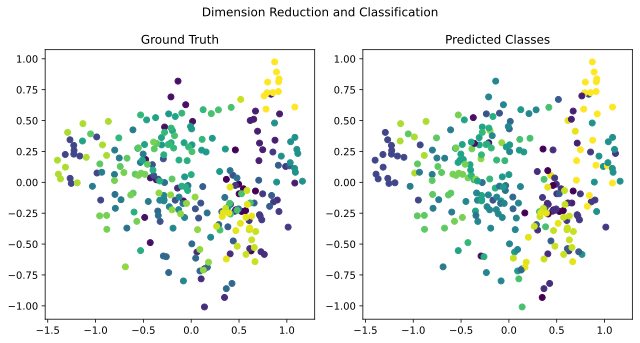

In [27]:
fig = plt.figure('Dimension Reduction and Classification')
fig.set_figwidth(9)
ax = fig.add_subplot(121)
ax.scatter(pts[:,0], pts[:,1], c=y)
ax.set_title('Ground Truth')
ax.set_box_aspect(1)
ax = fig.add_subplot(122)
ax.scatter(pts[:,0], pts[:,1], c=model.predict(X))
ax.set_title('Predicted Classes')
ax.set_box_aspect(1)
fig.suptitle('Dimension Reduction and Classification')
fig.tight_layout()

In [28]:
X, y = pickle.load(open("datasets/testWordRecognition.pickle", 'rb'))
predY = model.predict(X)

In [29]:
print(classification_report(y, predY))

              precision    recall  f1-score   support

           1       0.20      0.17      0.18        12
           2       0.00      0.00      0.00        12
           3       0.50      0.08      0.14        12
           4       0.22      0.17      0.19        12
           5       0.53      0.75      0.62        12
           6       0.45      0.75      0.56        12
           7       0.00      0.00      0.00        12
           8       0.08      0.08      0.08        12
           9       0.25      0.08      0.12        12
          10       0.59      0.83      0.69        12
          11       0.41      0.58      0.48        12
          12       0.06      0.17      0.09        12
          13       0.38      0.42      0.40        12
          14       0.40      0.17      0.24        12
          15       0.27      0.25      0.26        12
          16       0.00      0.00      0.00        12
          17       0.00      0.00      0.00        12
          18       0.00    

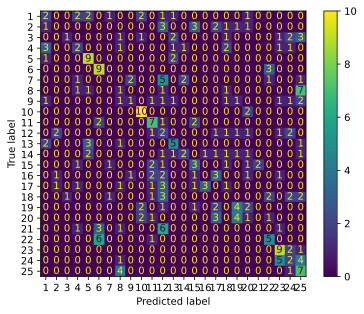

In [30]:
ConfusionMatrixDisplay.from_predictions(y, predY)

## r=3

### Fitting the data

In [31]:
model = MUDRA(r=3, n_iter=500, nBasis=6).fit(X, y)
pts = model.transform(X)

### Plot the estimated class functionals

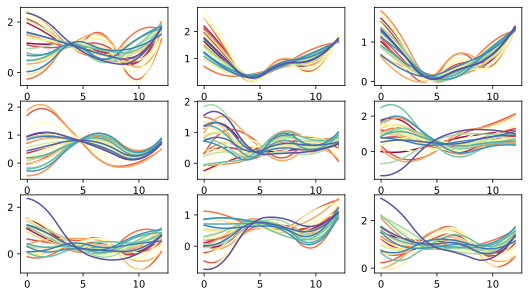

In [35]:
xs = np.linspace(0, 12, 100)
S = model.basis(xs).squeeze().T
fig, ax = plt.subplots(nrows=3, ncols=3)
fig.set_figwidth(9)
for i in range(model.n_classes):
    ys = S @ (model.lambda0_ + model.Lambda_ @ np.diag(model.alpha_[i]) @ model.xi_)
    for j in range(model.n_features):
        ax[j//3, j%3].plot(xs, ys[:,j], color=cmap[i])

### Cluster plots

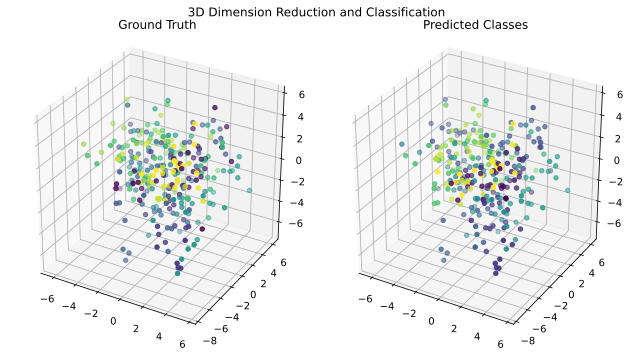

In [38]:
fig = plt.figure('3D Dimension Reduction and Classification')
fig.set_figwidth(9)
ax = fig.add_subplot(121, projection='3d')
ax.scatter(pts[:,0], pts[:,4], pts[:,8], c=y)
ax.set_title('Ground Truth')
ax.set_box_aspect((1, 1, 1))
ax = fig.add_subplot(122, projection='3d')
ax.scatter(pts[:,0], pts[:,4], pts[:,8], c=model.predict(X))
ax.set_title('Predicted Classes')
ax.set_box_aspect((1, 1, 1))
fig.suptitle('3D Dimension Reduction and Classification')
fig.tight_layout()